## Packages

In [10]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [15]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, threads = True)

[*********************100%***********************]  4 of 4 completed


In [16]:
df = raw_data.copy()

In [17]:
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]

In [18]:
df = df.iloc[1:]
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [19]:
df = df.droplevel(level=1, axis=1)

## Creating Returns

In [21]:
df['ret_spx'] = df.spx.pct_change(1).mul(100)
df['ret_ftse'] = df.ftse.pct_change(1).mul(100)
df['ret_dax'] = df.dax.pct_change(1).mul(100)
df['ret_nikkei'] = df.nikkei.pct_change(1).mul(100)

In [22]:
df['norm_ret_spx'] = df.ret_spx.div(df.ret_spx[1])*100
df['norm_ret_ftse'] = df.ret_ftse.div(df.ret_ftse[1])*100
df['norm_ret_dax'] = df.ret_dax.div(df.ret_dax[1])*100
df['norm_ret_nikkei'] = df.ret_nikkei.div(df.ret_nikkei[1])*100

## Splitting the Data

In [23]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

## Fitting a Model

In [24]:
df_train.columns

Index(['spx', 'dax', 'ftse', 'nikkei', 'ret_spx', 'ret_ftse', 'ret_dax',
       'ret_nikkei', 'norm_ret_spx', 'norm_ret_ftse', 'norm_ret_dax',
       'norm_ret_nikkei'],
      dtype='object')

In [38]:
price_arima100 = ARIMA(df_train['ftse'], order=(1,0,0))
results_price_arima100 = price_arima100.fit()
print(results_price_arima100.summary())

                               SARIMAX Results                                
Dep. Variable:                   ftse   No. Observations:                 5352
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -29376.023
Date:                Mon, 16 Jan 2023   AIC                          58758.045
Time:                        20:14:49   BIC                          58777.801
Sample:                    01-10-1994   HQIC                         58764.946
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5184.5182    461.248     11.240      0.000    4280.488    6088.548
ar.L1          0.9986      0.001   1219.381      0.000       0.997       1.000
sigma2      3424.0355     38.543     88.837      0.0

In [37]:
price_arima415 = ARIMA(df_train['ftse'], order=(4,1,5))
results_price_arima415 = price_arima415.fit()
print(results_price_arima415.summary())

                               SARIMAX Results                                
Dep. Variable:                   ftse   No. Observations:                 5352
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -29339.279
Date:                Mon, 16 Jan 2023   AIC                          58698.557
Time:                        20:14:31   BIC                          58764.408
Sample:                    01-10-1994   HQIC                         58721.558
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7129      0.109      6.529      0.000       0.499       0.927
ar.L2         -0.6551      0.123     -5.329      0.000      -0.896      -0.414
ar.L3          0.0959      0.132      0.727      0.4

## Simple Forecasting

In [27]:
df_train.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [39]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = '2014-07-16'
end_date = '2015-01-01'

In [40]:
df_pred = results_price_arima415.predict(start = start_date, end = end_date)

Text(0.5, 1.0, 'Prediction')

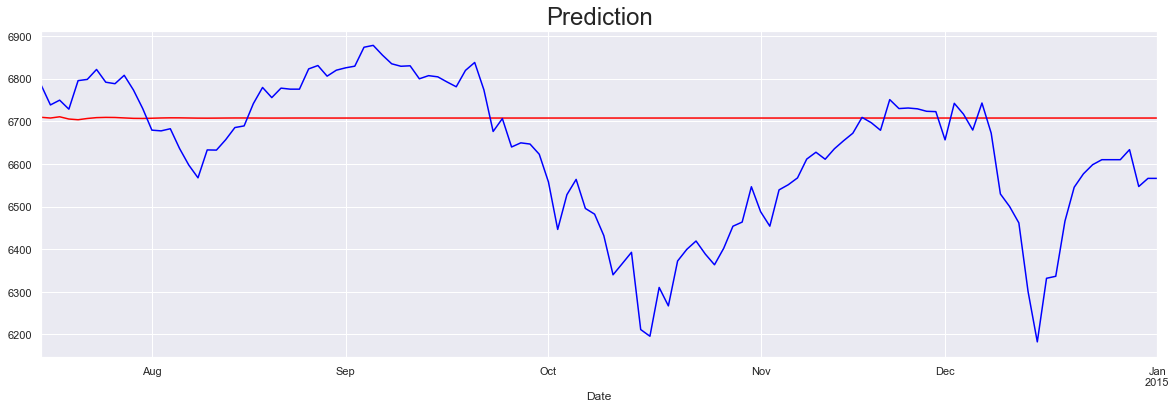

In [41]:
df_pred.plot(figsize=(20,6), color = "red")
df_test['ftse'][start_date:end_date].plot(color="blue")
plt.title("Prediction", size=24)

### Using Returns Instead

In [42]:
end_date = '2015-01-01'

returns_arima100 = ARIMA(df_train['ret_ftse'], order=(1,0,0))
results_returns_arima100 = returns_arima100.fit()
pred_returns_arima100 = results_returns_arima100.predict(start = start_date, end=end_date)

Text(0.5, 1.0, 'Predictions vs Actuals (Returns)')

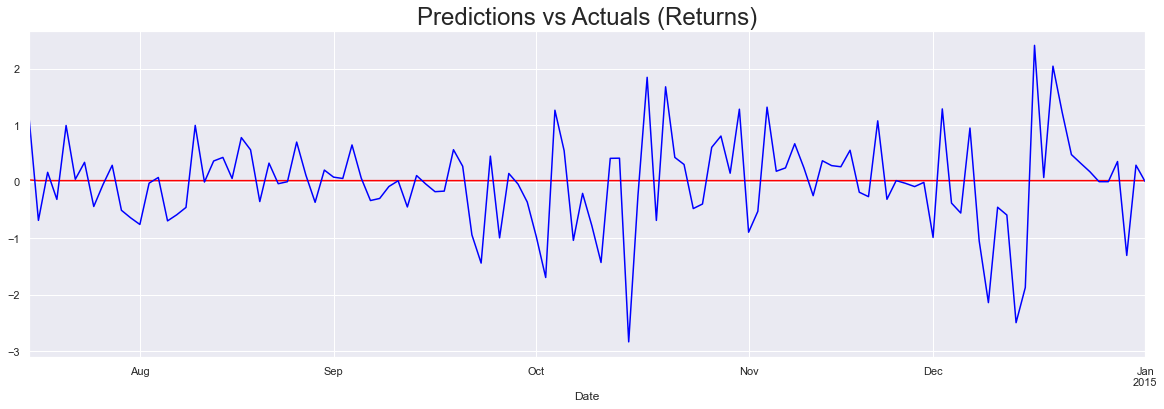

In [44]:
pred_returns_arima100.plot(figsize=(20,6), color = "red")
df_test['ret_ftse'][start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals (Returns)", size=24)

In [53]:
returns_arima405 = ARIMA(df_train['ret_ftse'][1:], order=(4,0,5))
results_returns_arima405 = returns_arima405.fit()
pred_returns_arima405 = results_returns_arima405.predict(start = start_date, end=end_date)

Text(0.5, 1.0, 'Predictions vs Actuals (Returns)')

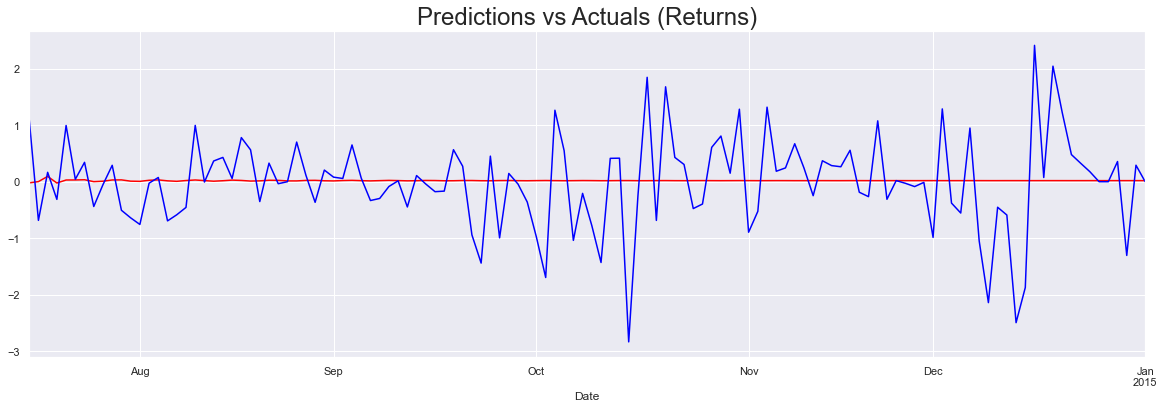

In [54]:
pred_returns_arima405.plot(figsize=(20,6), color = "red")
df_test['ret_ftse'][start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals (Returns)", size=24)

In [49]:
pred_returns_arima405.head()

2014-07-16   -0.020500
2014-07-17    0.001935
2014-07-18    0.093925
2014-07-21   -0.022861
2014-07-22    0.029875
Freq: B, Name: predicted_mean, dtype: float64

### ARMAX

In [56]:
returns_arimax405 = ARIMA(df_train['ret_ftse'][1:], order=(4, 0, 5), exog=df_train[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])
results_returns_arimax405 = returns_arimax405.fit()
pred_returns_arimax405 = results_returns_arimax405.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

Text(0.5, 1.0, 'Predictions vs Actuals (Returns)')

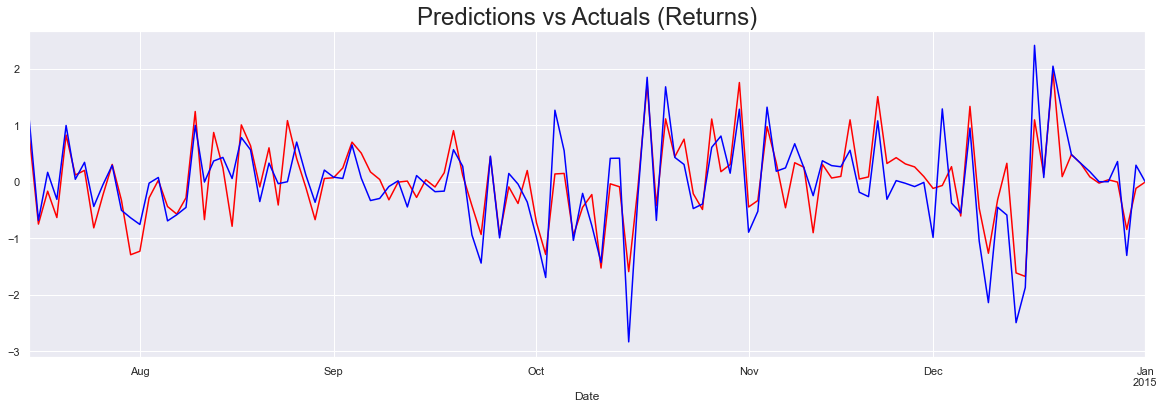

In [57]:
pred_returns_arimax405.plot(figsize=(20,6), color = "red")
df_test['ret_ftse'][start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals (Returns)", size=24)

    forecast vs prediction
    predictions are used for discussing in-sample estimations
    forecasts are used for discussing out-of-sample estimations
    
    MAX models are therefore not so useful in forecasting applications

### SARMA

### SARIMAX

### Auto ARIMA

### Comparing All the Models (Returns)

### Forecasting Volatility

### Multvariate Regression Model